<a href="https://colab.research.google.com/github/chanchalagrawal0107/Customer-Churn-Prediction-ML-/blob/main/Customer%20Churn%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Model: Random Forest
Accuracy: 0.7857
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.64      0.44      0.52       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.79      0.77      1409

--------------------------------------------------
Model: SVM
Accuracy: 0.7871
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1035
           1       0.70      0.35      0.46       374

    accuracy                           0.79      1409
   macro avg       0.75      0.65      0.67      1409
weighted avg       0.77      0.79      0.76      1409

--------------------------------------------------
Model: XGBoost
Accuracy: 0.7850
Classification Report:
              precision    recall  f1-score   support

           0       0.8

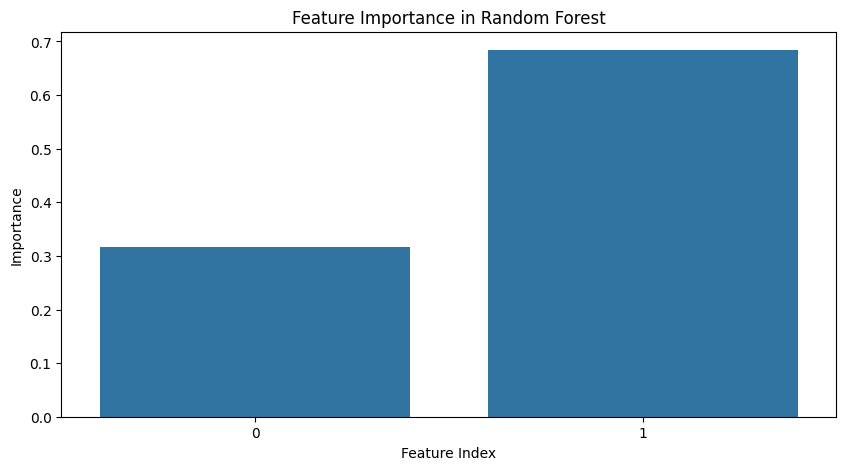

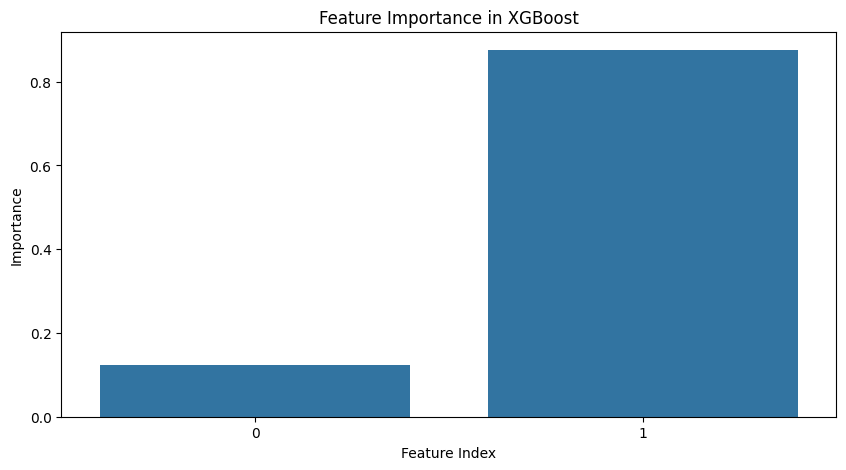

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/Telecom_customer_churn.csv")

# Handle Categorical Data (Label Encoding)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define Features (X) and Target Variable (y)
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# Feature Selection (Top k features)
selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_selected = selector.fit_transform(X, y)

# Dimensionality Reduction with PCA (Keeping 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_selected)

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Models with Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
}

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Train SVM
svm = SVC(probability=True)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

# Train XGBoost (Fixed Warning)
xgb = XGBClassifier(verbosity=1, eval_metric='logloss', random_state=42)
random_xgb = RandomizedSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_iter=10, n_jobs=-1, random_state=42)
random_xgb.fit(X_train, y_train)
best_xgb = random_xgb.best_estimator_
# Train Logistic Regression (Baseline Model)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Train AdaBoost (Weak Learners)
# Train AdaBoost (Fixed Warning)
ada = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)
ada.fit(X_train, y_train)

# Evaluate Models
models = {
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": best_xgb,
    "Logistic Regression": log_reg,
    "AdaBoost": ada
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 50)

# Feature Importance (for RF & XGBoost)
plt.figure(figsize=(10, 5))
if hasattr(best_rf, "feature_importances_"):
    sns.barplot(x=np.arange(len(best_rf.feature_importances_)), y=best_rf.feature_importances_)
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.title("Feature Importance in Random Forest")
    plt.show()

if hasattr(best_xgb, "feature_importances_"):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=np.arange(len(best_xgb.feature_importances_)), y=best_xgb.feature_importances_)
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.title("Feature Importance in XGBoost")
    plt.show()